# Training y Predicción Simple_2

Basado en "ann_train.py". 

Los datos contienen eventos de la navegación de usuarios en una web. 

Objetivo: hacer predicciones sobre las acciones de los usuarios una vez que tenemos ciertos datos del usuario.

- is_mobile: si usa un dispositivo movil para navegar
- n_products_viewed: numero de productos visitados
- visit_duration: duracion de la visita en minutos
- is_returning_visitor: 0 - nuevo, 1 - visitante que vuelve
- time_of_day: se ha segmentado el dia en 4 partes, 0 (de 00.00 a 06.00), 1 (de 06.00 a 12:00), etc..
- user_action:0 - bounce, 1 - add_to_cart, 2 - begin_checkout, 3 - finish_checkout 

Este es un problema de clasificación donde podemos usar Logistic regression con 2 clases (0 o cualquiera de las otras) o *"multi-class classification"*. 

In [1]:
import numpy as np
import numpy as np
import pandas as pd
import os
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [2]:
def y2indicator(y, K):
    N = len(y)
    ind = np.zeros((N, K))
    for i in xrange(N):
        ind[i, y[i]] = 1
    return ind

In [3]:
# Funcion para leer y transformar los datos
def get_data():
    df = pd.read_csv('ecommerce_data.csv')

    # lo pasamos a un array de numpy
    data = df.as_matrix()

    # Separamos los datos y la etiqueta
    X = data[:,:-1]   # todo menos la ultima
    Y = data[:,-1]    # solo la ultima

    # normalizamos las columnas 1 y 2
    X[:,1] = (X[:,1] - X[:,1].mean()) / X[:,1].std()
    X[:,2] = (X[:,2] - X[:,2].mean()) / X[:,2].std()

    # creamos una nueva matriz X2 con el numero correcto de columnas
    N, D = X.shape
    X2 = np.zeros((N, D+3))
    X2[:,0:(D-1)] = X[:,0:(D-1)] # no-categoricas

    # hacemos el one-hot encoding para las categoricas
    for n in xrange(N):
        t = int(X[n,D-1])
        X2[n,t+D-1] = 1

    return X2, Y

In [4]:
# make predictions
def softmax(a):
    expA = np.exp(a)
    return expA / expA.sum(axis=1, keepdims=True)

In [5]:
def forward(X, W1, b1, W2, b2):
    Z = np.tanh(X.dot(W1) + b1)
    return softmax(Z.dot(W2) + b2), Z

In [6]:
def predict(P_Y_given_X):
    return np.argmax(P_Y_given_X, axis=1)

In [7]:
# calculate the accuracy
def classification_rate(Y, P):
    return np.mean(Y == P)

In [8]:
def cross_entropy(T, pY):
    return -np.mean(T*np.log(pY))

## main ( )

### 1. Leemos datos e inicializamos variables

In [9]:
X, Y = get_data()
X, Y = shuffle(X, Y)
Y = Y.astype(np.int32)
M = 5
D = X.shape[1]
K = len(set(Y))

In [10]:
# creamos los datasets de train y test
Xtrain = X[:-100]
Ytrain = Y[:-100]
Ytrain_ind = y2indicator(Ytrain, K)
Xtest = X[-100:]
Ytest = Y[-100:]
Ytest_ind = y2indicator(Ytest, K)

### 2. Inicializamos los pesos

In [11]:
# inicializamos los pesos en forma random
W1 = np.random.randn(D, M)
b1 = np.zeros(M)
W2 = np.random.randn(M, K)
b2 = np.zeros(K)

### 3. Entrenamos

In [12]:
# lazo de training
train_costs = []
test_costs = []
learning_rate = 0.001
for i in xrange(10000):
    pYtrain, Ztrain = forward(Xtrain, W1, b1, W2, b2)
    pYtest, Ztest = forward(Xtest, W1, b1, W2, b2)

    ctrain = cross_entropy(Ytrain_ind, pYtrain)
    ctest = cross_entropy(Ytest_ind, pYtest)
    train_costs.append(ctrain)
    test_costs.append(ctest)

    # Hacemos el gradient descent
    W2 -= learning_rate*Ztrain.T.dot(pYtrain - Ytrain_ind)
    b2 -= learning_rate*(pYtrain - Ytrain_ind).sum(axis=0)
    dZ = (pYtrain - Ytrain_ind).dot(W2.T) * (1 - Ztrain*Ztrain)
    W1 -= learning_rate*Xtrain.T.dot(dZ)
    b1 -= learning_rate*dZ.sum(axis=0)
    if i % 1000 == 0:
        print i, ctrain, ctest

0 0.527398182132 0.556818202804
1000 0.0283784483381 0.0325722588708
2000 0.0174428784446 0.0396736421866
3000 0.0137096252671 0.0429411141591
4000 0.0115359790879 0.0457715095762
5000 0.0101110427908 0.0488550636122
6000 0.00913282632565 0.0518723975643
7000 0.00841554833335 0.0545548771285
8000 0.00786213249393 0.0569110402364
9000 0.00741970792143 0.0589978707506


In [13]:
print "Ratio de Clasificacion (training):", classification_rate(Ytrain, predict(pYtrain))
print "Ratio de Clasificacion (test):", classification_rate(Ytest, predict(pYtest))

Ratio de Clasificacion (training): 0.9925
Ratio de Clasificacion (test): 0.95


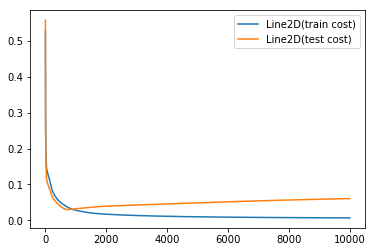

In [14]:
legend1, = plt.plot(train_costs, label='train cost')
legend2, = plt.plot(test_costs, label='test cost')
plt.legend([legend1, legend2])
plt.show()